In [14]:
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal
from seaborn import heatmap
from scipy.spatial.distance import mahalanobis as mdist
ND=multivariate_normal.pdf#input: x, mean, cov, allow_singular=False)
from sklearn.metrics import classification_report,confusion_matrix
from seaborn import heatmap

In [15]:
#reading in the seperated datasets skipping the headwr row
Train=np.genfromtxt('Training.csv',skip_header=1,delimiter=',')
Val=np.genfromtxt('Validation.csv',skip_header=1,delimiter=',')
Test=np.genfromtxt('Test.csv',skip_header=1,delimiter=',')

In [16]:
# creating dictonary to convert between numerical and str labels
names={'Setosa':0,'Versicolor':1,'Virginica':2}
#seperating the arrays read in above to feature vectors and labels
TrainX=Train[:,0:2]
TrainY=Train[:,2]

ValX=Val[:,0:2]
ValY=Val[:,2]

TestX=Test[:,0:2]
TestY=Test[:,2]

In [17]:
class NDA:
    def __init__(self, X,Y, kind,nu=1,depen='Gen'):
        #initalizing given params into variabls to be refrence later
        self.dependancy=depen
        self.X=X
        self.kind=kind
        self.Y=Y
        self.nu=nu
        #Allocating empty to be written into later
        self.p=np.zeros(3)
        self.mu=np.zeros([3,2])
        self.C=list()
        self.Cpool=np.zeros([2,2])
        
        #calulating the p_k sample means(mu) and Covarinece matrix for each of the classes
        for l in [0,1,2]:
            loc=np.where(self.Y==l)[0]
            self.p[l]=len(loc)/len(self.Y)
            self.mu[l]=np.mean(self.X[loc],axis=0)
            self.C.append(np.cov(self.X[loc].T))
        #calulatung the pooled covarince matric
        for n in range(len(self.C)):
            self.Cpool+=self.C[n]*self.p[n]
       #if the kid of NDA is LDA then the Covarince 
        if self.kind=='LDA':
            self.C=[self.Cpool,self.Cpool,self.Cpool]
       #going though the Covavarince list and changing it to the MLE covaience matrix 
        for n in range(len(self.C)):
            if self.kind=='QDA':
                self.C[n]=self.nu*self.C[n]+(1-nu)*self.Cpool
            self.C[n]=self.C_MLE(self.C[n],self.dependancy)
    def C_MLE(self,C,kind='Gen'):
        if kind=='Gen':
            return C #returning the array back if its general
        if kind=='Ind':
            return np.diag(np.diag(C)) #setting off axis terms to 0
        if kind=='Iso':
            D=len(C)
            return (1/D)*np.matrix.trace(C)*np.identity(D) #making the isotropic covarince matrix
        else:
            print(kind,' not reconized please choose either Gen, Indp, or Iso') #error statment
    def PlotSample(self,colors=['red','lime','blue'],markers=['.','*']):
        Rx=np.linspace(0.5,7.5,100)#creating X range for feature space
        Ry=np.linspace(-0.5,3.0,100)#creating Y range for feature space
        plt.figure()# creating figure to plot to
        for i in [0,1,2]: # itterating over labels
            loc=np.where(self.Y==i)  #fiding location of label
            #plotting feature vectors for the itteretor label
            plt.scatter(self.X[loc,0],self.X[loc,1],color=colors[i],marker=markers[0],label=list(names.keys())[i]+' (Sample Mean: *)',zorder=1000)
            #plotting sample mean
            plt.scatter(self.mu[i,0],self.mu[i,1],color=colors[i],marker=markers[1],zorder=1000)
            #creating empty array for proablities 
            p=np.zeros([len(Rx),len(Ry)])
            #itteringating over Xand Ys to calulate the Mdistance at each point
            for x in range(len(Rx)):
                for y in range(len(Ry)):
                    #calulating the mahalanobis distance
                    p[x,y]=mdist([Rx[x],Ry[y]],self.mu[i],self.C[i])
            #plotting a filled contour plot of for the 50% confidance 
            plt.contourf(Rx,Ry,p,levels=[0,0.5],alpha=0.25,colors=colors[i])
            plt.contourf(Rx,Ry,p,levels=[0,0.9],alpha=0.25,colors=colors[i])
        #plot housekeeping like setting limits and titles
        plt.xlim([0.5,7.5])
        plt.ylim([-0.5,3.0])
        plt.legend()
        title="Sample Plot " + self.kind + ' '+ self.dependancy
        if self.kind == 'QDA' and self.nu !=1 :
            title+= ' nu: '+ str(self.nu)
        plt.title(title)
        plt.xlabel('Petal Length [cm]')
        plt.ylabel('Petal Width [cm]')
        plt.show()
    def PlotPredictions(self,colors=['red','lime','blue']):
        Rx=np.linspace(0.5,7.5,100)#creating X range for feature space
        Ry=np.linspace(-0.5,3.0,100)
        pred=np.zeros([len(Rx),len(Ry)])
        for x in range(len(Rx)):
            for y in range(len(Ry)):
                #calulating the mahalanobis distance
                pred[x,y]=self.Predict([[Rx[x],Ry[y]]])[0]
        cmap=ListedColormap(colors)
        plt.plot()
        plt.pcolormesh(Rx,Ry,pred,cmap=cmap,alpha=0.5)
        plt.xlim([0.5,7.5])
        plt.ylim([-0.5,3.0])
        title="Decision Reigon Plot " + self.kind + ' '+ self.dependancy
        if self.kind == 'QDA' and self.nu !=1 :
            title+= ' nu: '+ str(self.nu)
        plt.title(title)
        plt.title(title)
        plt.xlabel('Petal Length [cm]')
        plt.ylabel('Petal Width [cm]')
        plt.show()
    def Predict(self,testX):
        out=[]#creating empty list to put the prodicted labels in
        for xi in testX: #itterating over the features vectors
            yhat=np.zeros(3)
            for i in [0,1,2]:
                N_d=ND(xi,self.mu[i],self.C[i])# calculating the probalility for each sample
                if N_d>0:#had probelm wheere this was comming out neative so i have this to set the error to nan
                    yhat[i]=np.log(N_d)+np.log(self.p[i])
                else:
                    yhat[i]=np.nan
            out.append(yhat)
        return np.nanargmax(np.array(out),axis=1)# reurting the argument of the max predition to assign label

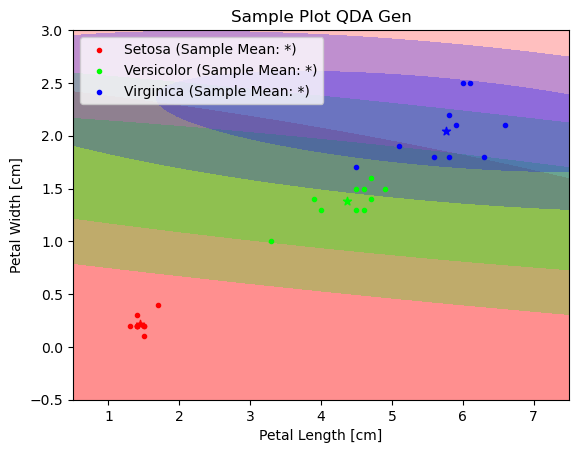

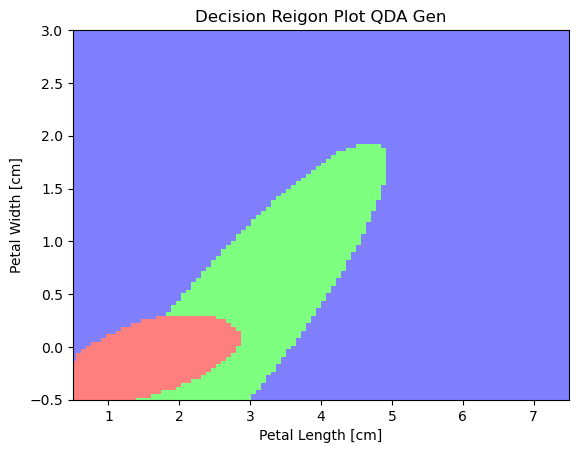

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



<AxesSubplot:>

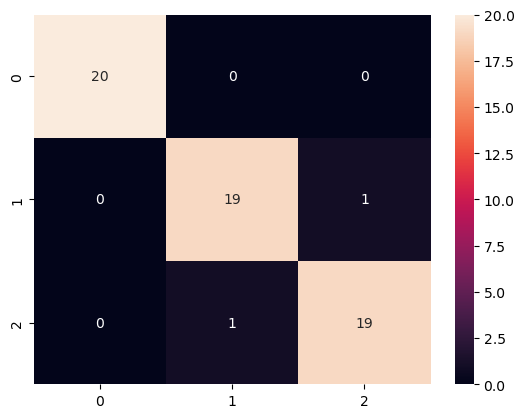

In [18]:
Model1=NDA(TrainX,TrainY,"QDA")#initializing and thereofre training the model
Model1.PlotSample()# plotting the sample with 50% shaded reigons
Y=Model1.Predict(ValX) # prediciting the validation set
Model1.PlotPredictions()#plotting decision reigons for Model 
print(classification_report(ValY,Y)) # giving the classifcation report
heatmap(confusion_matrix(ValY, Y),annot=True)# displying the confustionm matrix

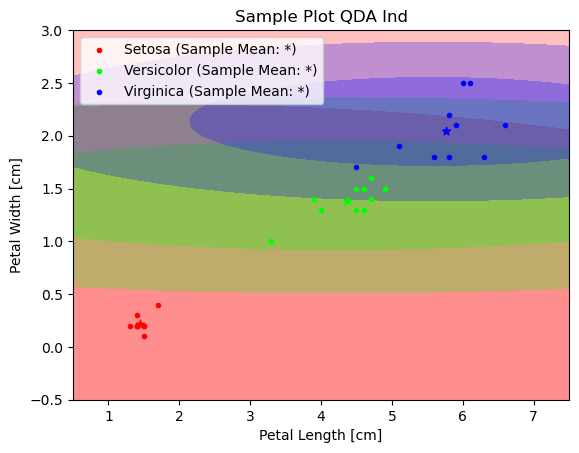

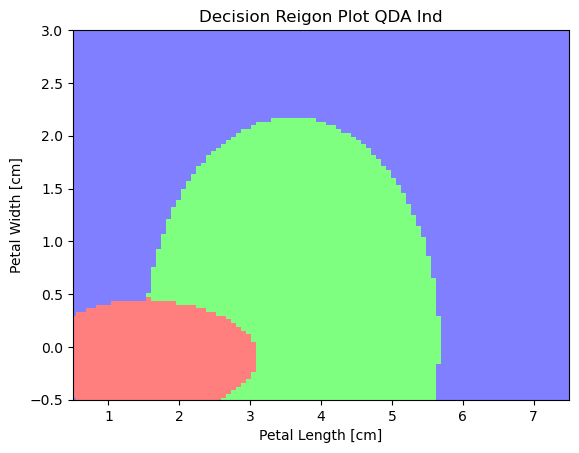

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.90      0.92        20
         2.0       0.90      0.95      0.93        20

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



<AxesSubplot:>

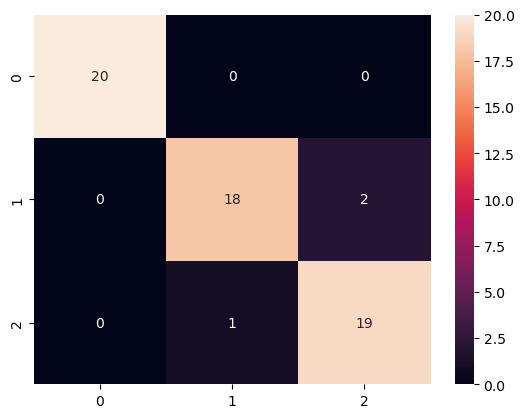

In [19]:
Model2=NDA(TrainX,TrainY,"QDA",depen='Ind')
Model2.PlotSample()
Y=Model2.Predict(ValX)
Model2.PlotPredictions()
print(classification_report(ValY,Y))
heatmap(confusion_matrix(ValY, Y),annot=True)

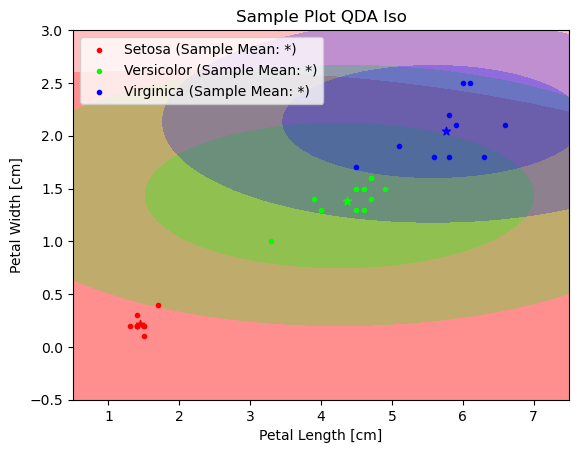

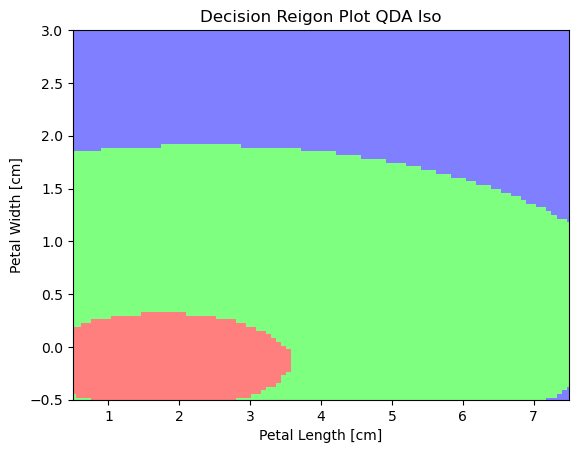

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.83      1.00      0.91        20
         2.0       1.00      0.80      0.89        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



<AxesSubplot:>

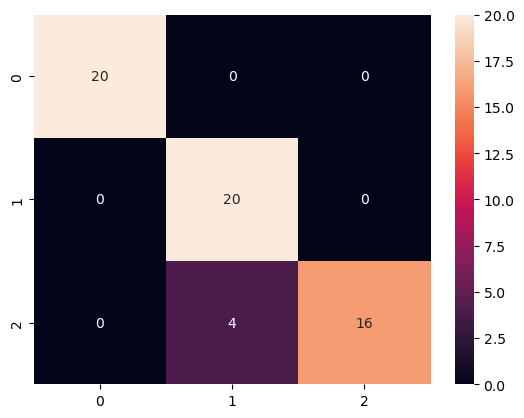

In [20]:
Model3=NDA(TrainX,TrainY,"QDA",depen='Iso')
Y=Model3.Predict(ValX)
Model3.PlotSample()
Model3.PlotPredictions()
print(classification_report(ValY,Y))
heatmap(confusion_matrix(ValY, Y),annot=True)

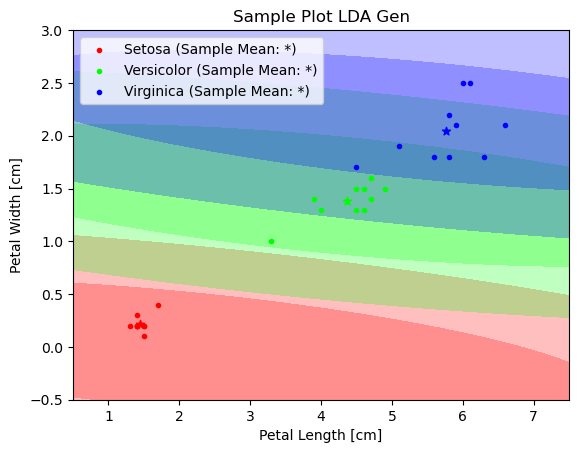

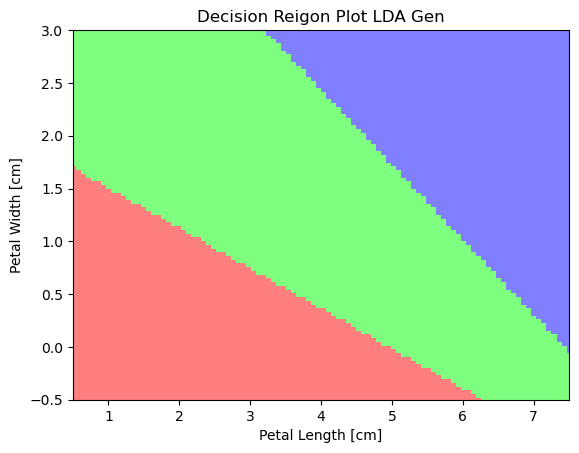

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.91      1.00      0.95        20
         2.0       1.00      0.90      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



<AxesSubplot:>

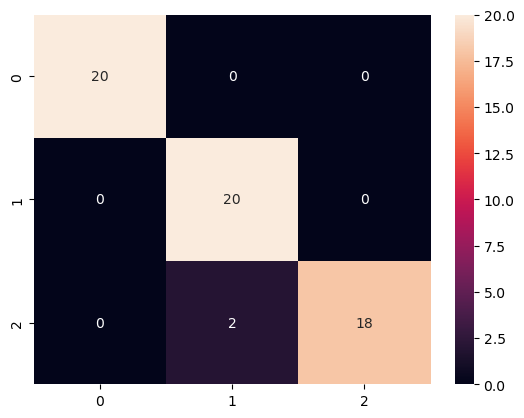

In [21]:
Model4=NDA(TrainX,TrainY,"LDA")
Y=Model4.Predict(ValX)
Model4.PlotSample()
Model4.PlotPredictions()
print(classification_report(ValY,Y))
heatmap(confusion_matrix(ValY, Y),annot=True)

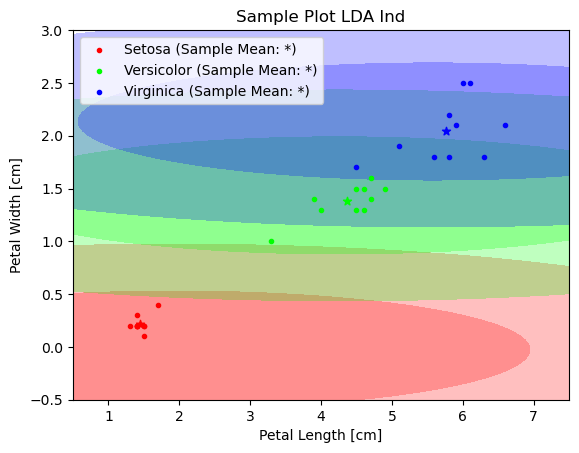

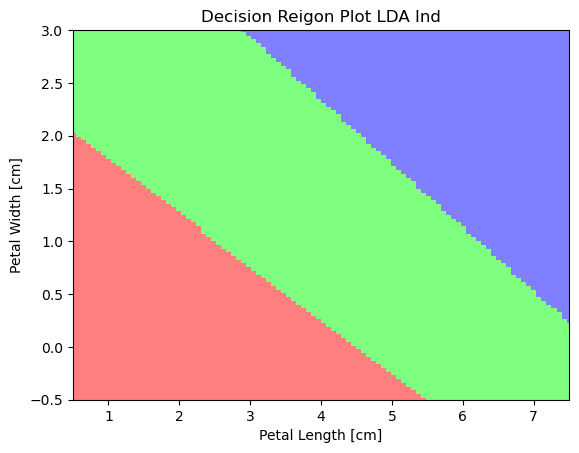

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.91      1.00      0.95        20
         2.0       1.00      0.90      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



<AxesSubplot:>

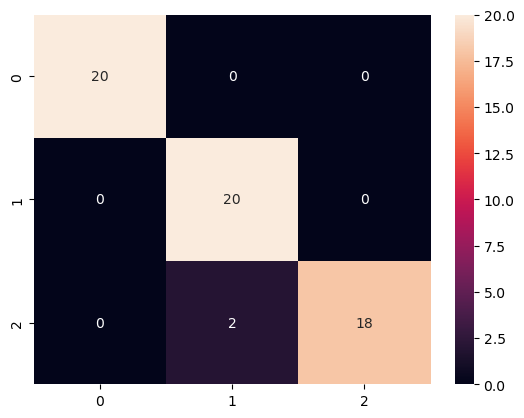

In [22]:
Model5=NDA(TrainX,TrainY,"LDA",depen='Ind')
Y=Model5.Predict(ValX)
Model5.PlotSample()
Model5.PlotPredictions()
print(classification_report(ValY,Y))
heatmap(confusion_matrix(ValY, Y),annot=True)

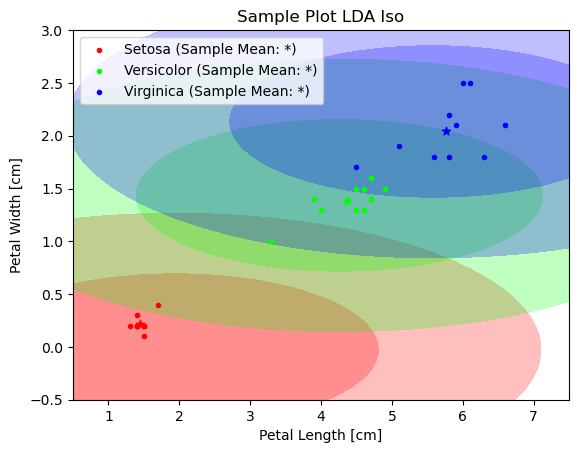

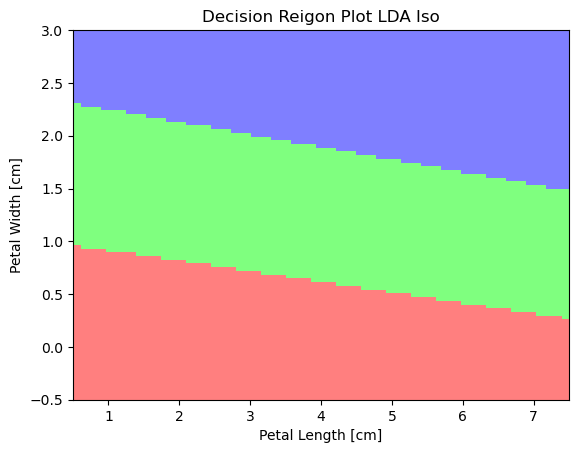

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.80      1.00      0.89        20
         2.0       1.00      0.75      0.86        20

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



<AxesSubplot:>

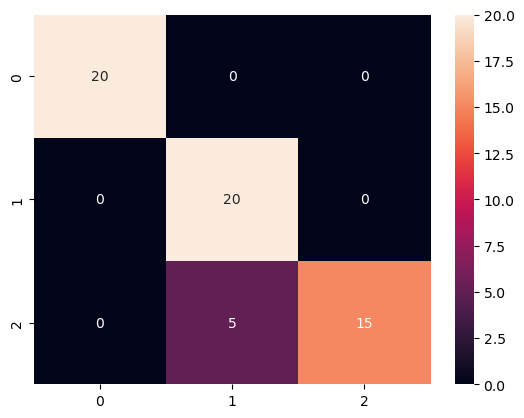

In [23]:
Model6=NDA(TrainX,TrainY,"LDA",depen='Iso')
Y=Model6.Predict(ValX)
Model6.PlotSample()
Model6.PlotPredictions()
print(classification_report(ValY,Y))
heatmap(confusion_matrix(ValY, Y),annot=True)

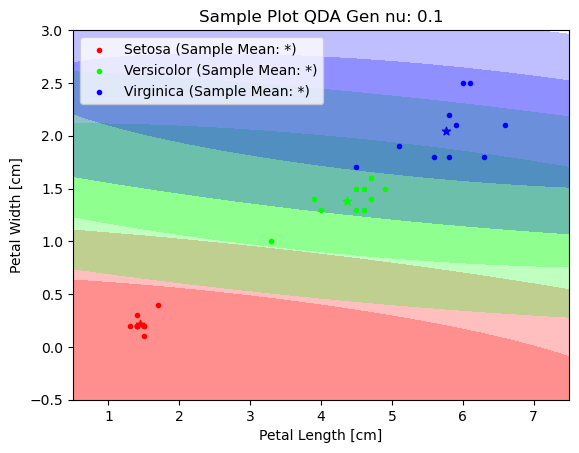

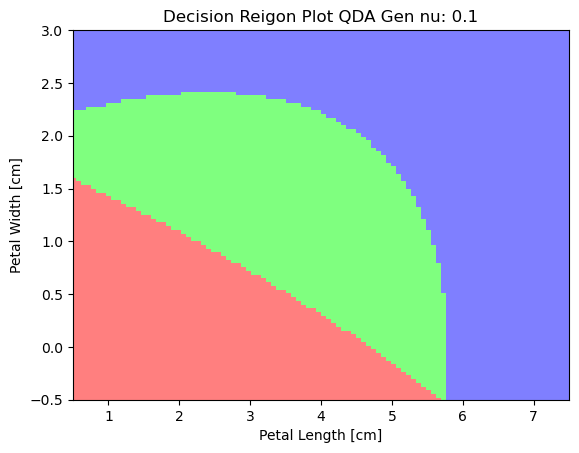

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



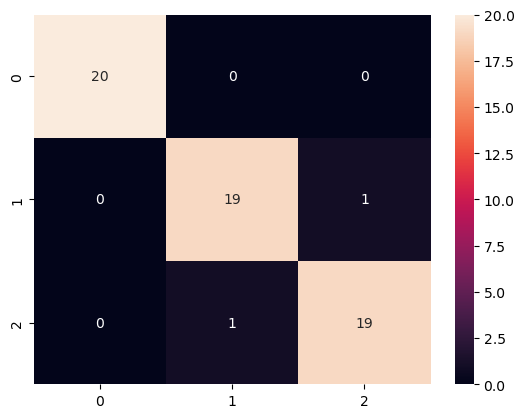

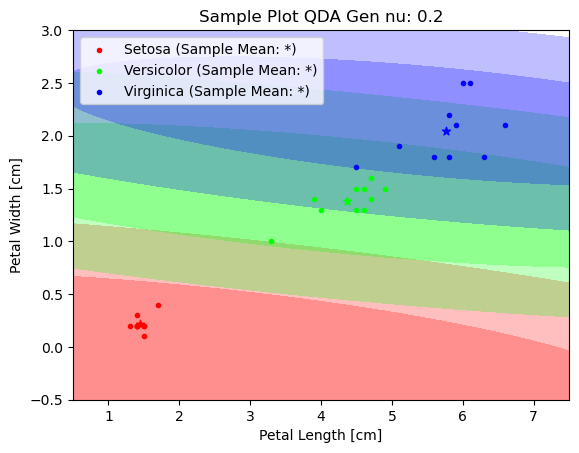

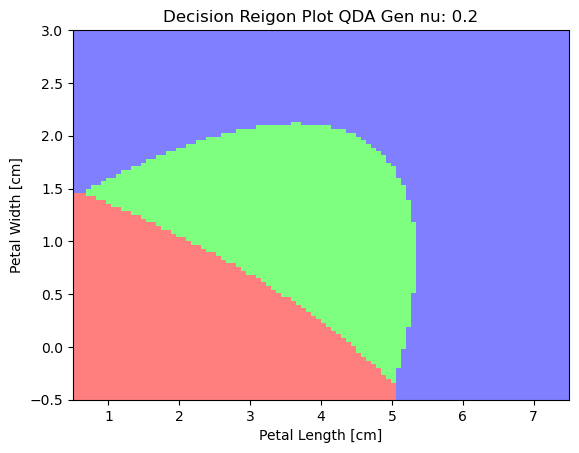

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



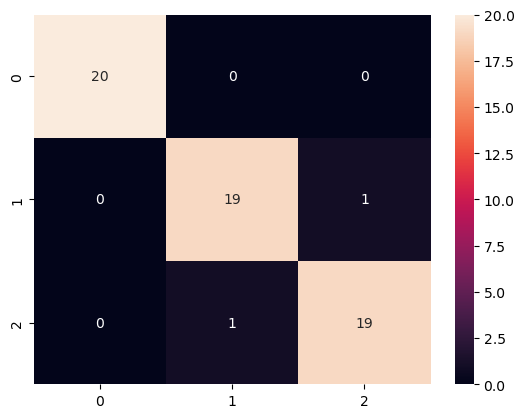

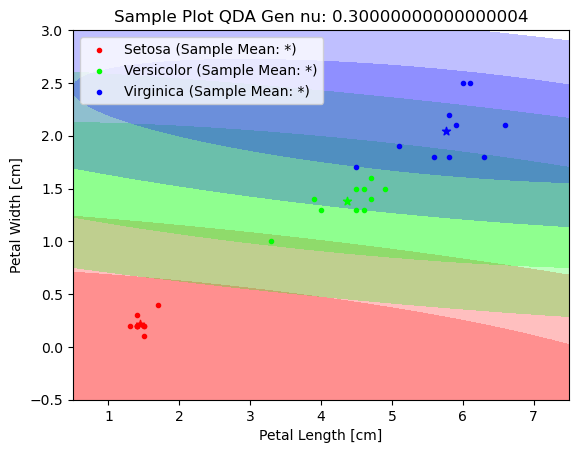

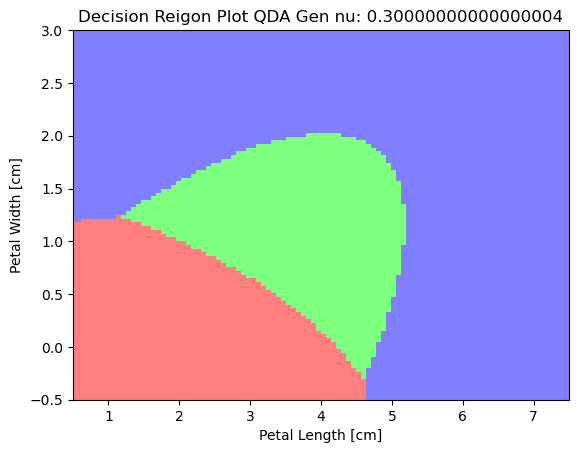

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



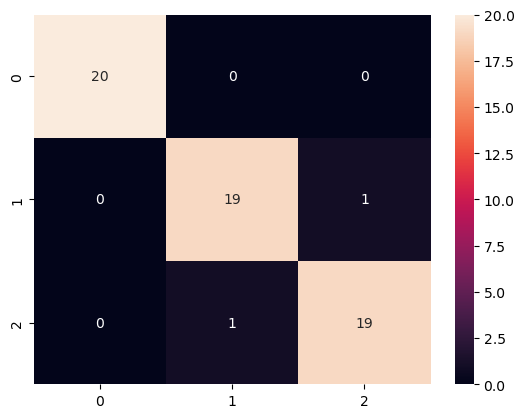

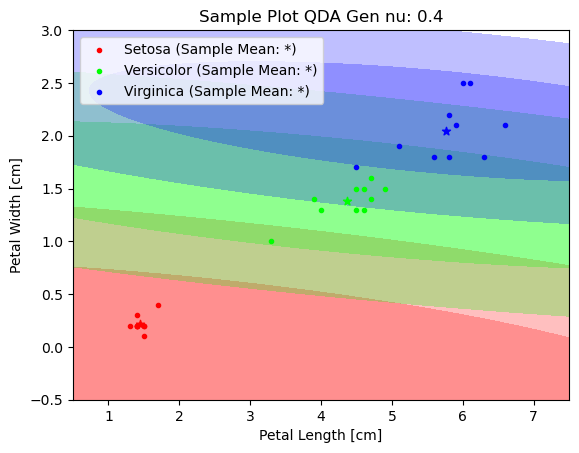

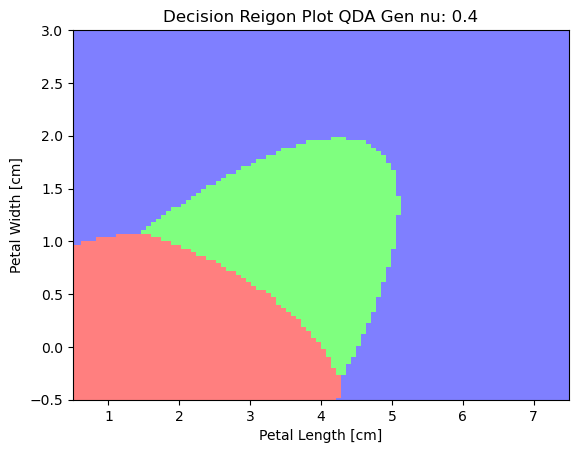

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



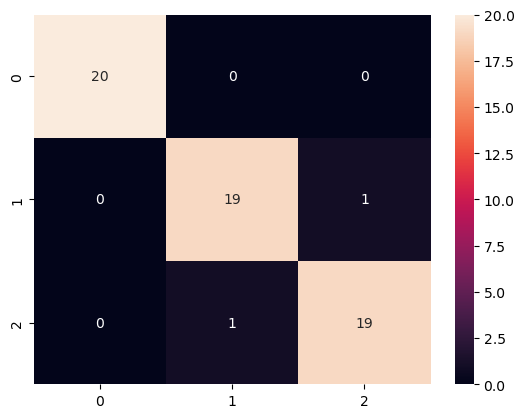

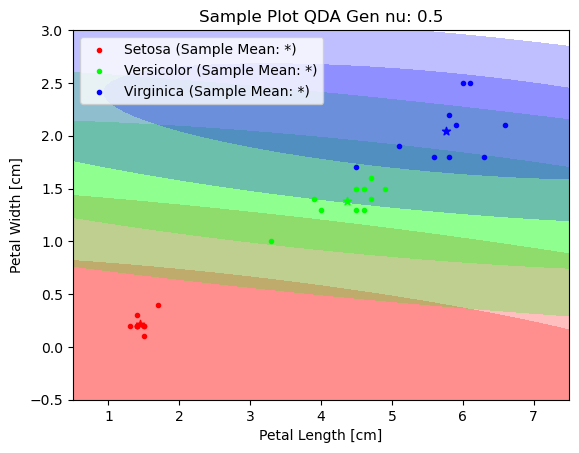

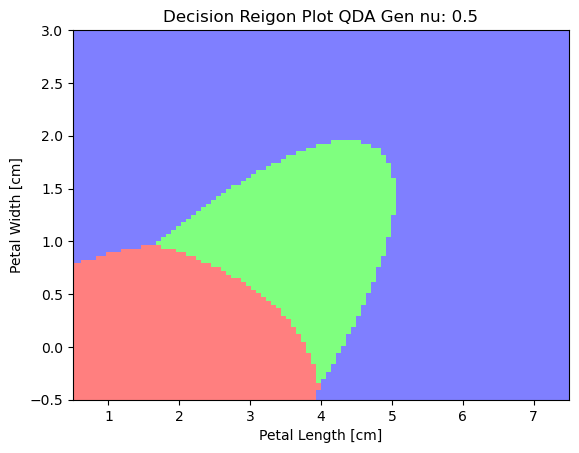

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



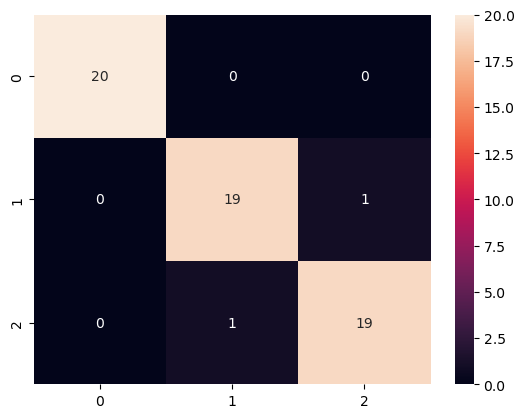

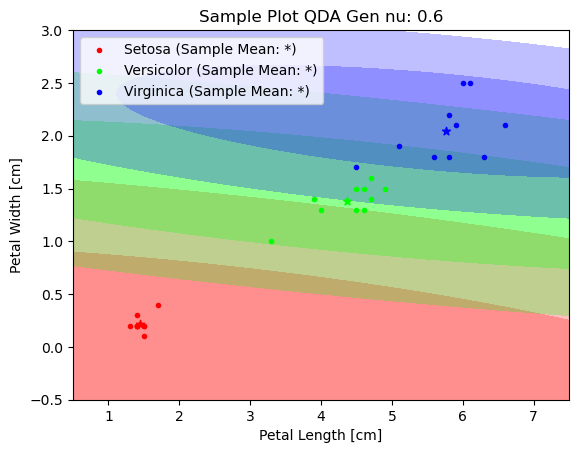

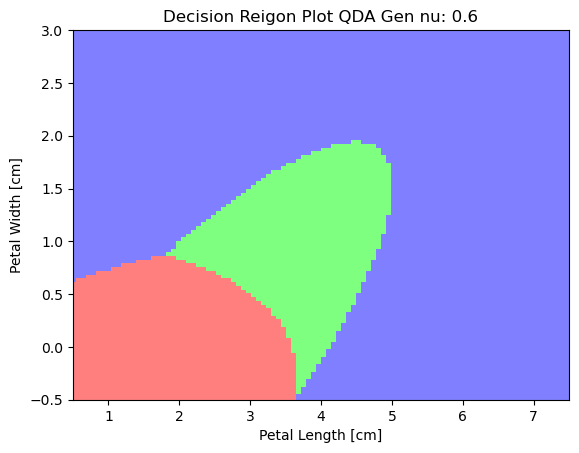

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



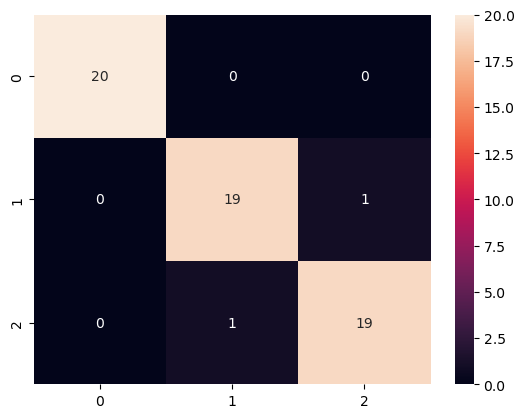

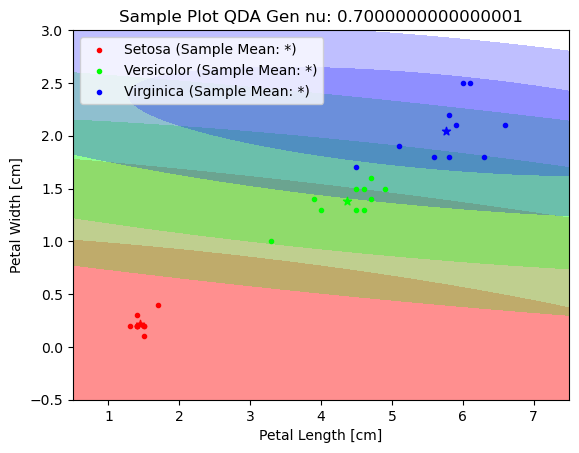

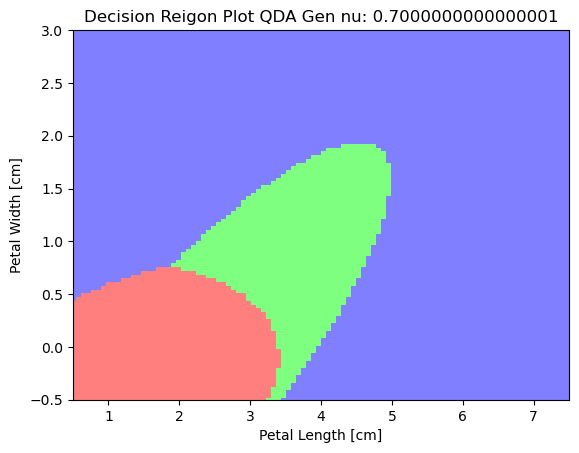

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



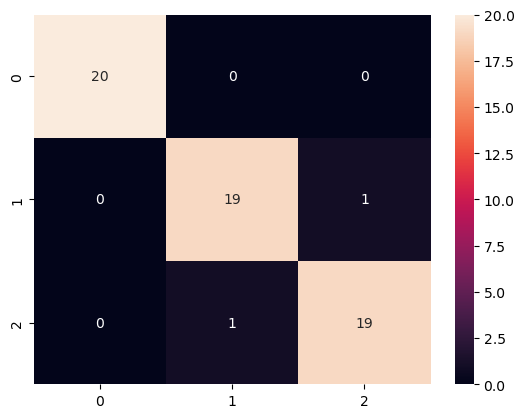

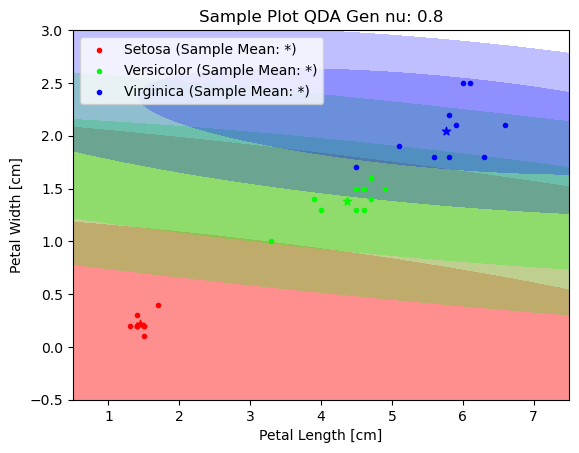

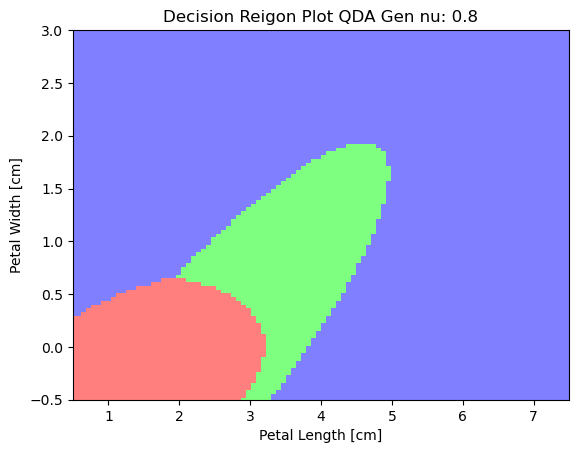

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



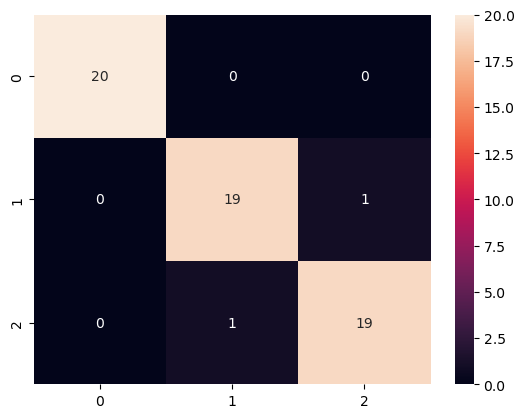

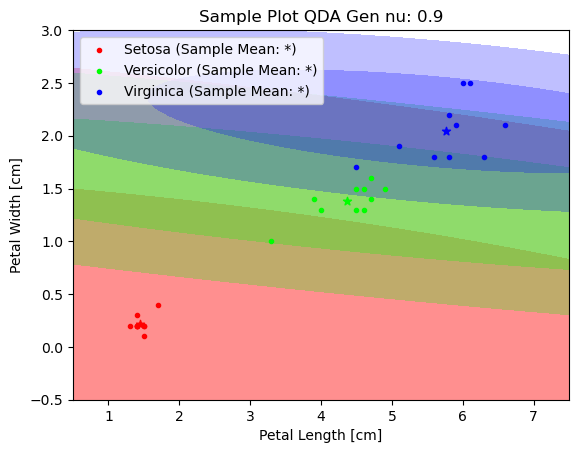

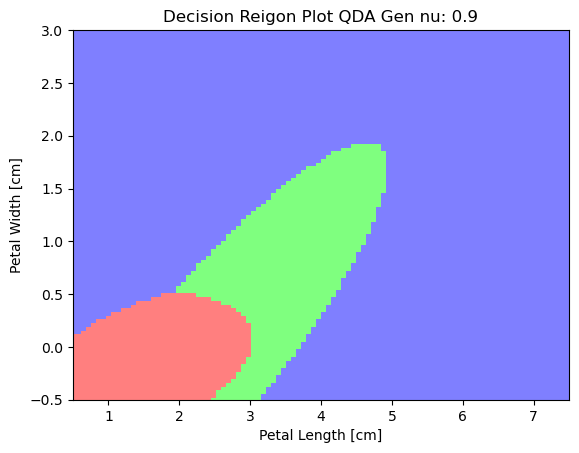

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



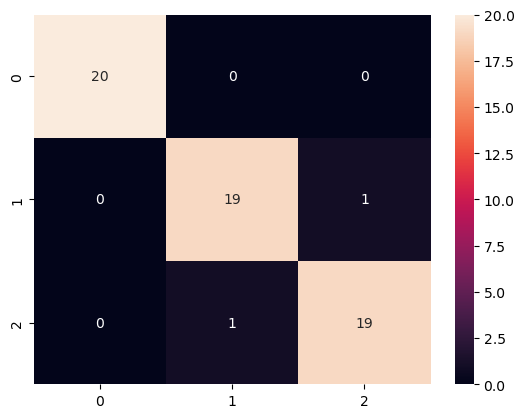

In [24]:
nus=np.arange(0.1,1.0,0.1)
for nu in nus:
    Model1=NDA(TrainX,TrainY,"QDA",nu=nu)
    Model1.PlotSample()
    Y=Model1.Predict(ValX)
    Model1.PlotPredictions()
    print(classification_report(ValY,Y))
    heatmap(confusion_matrix(ValY, Y),annot=True)


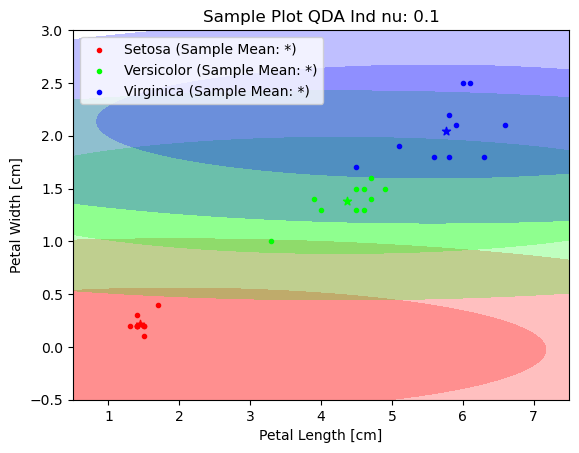

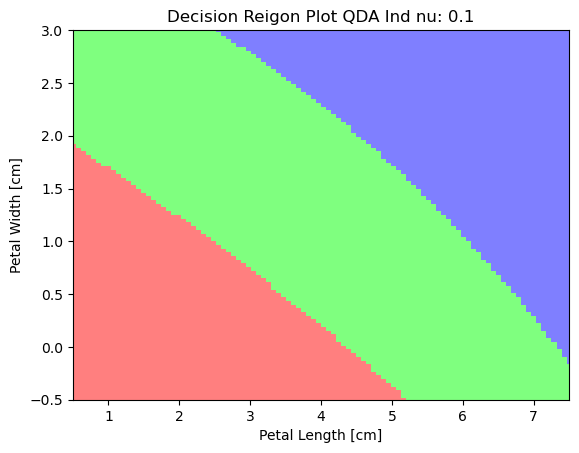

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.91      1.00      0.95        20
         2.0       1.00      0.90      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



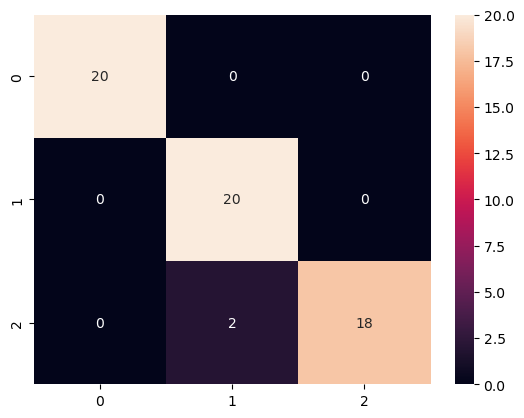

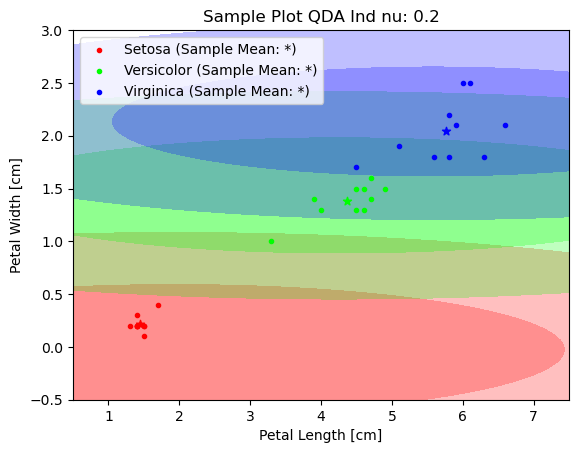

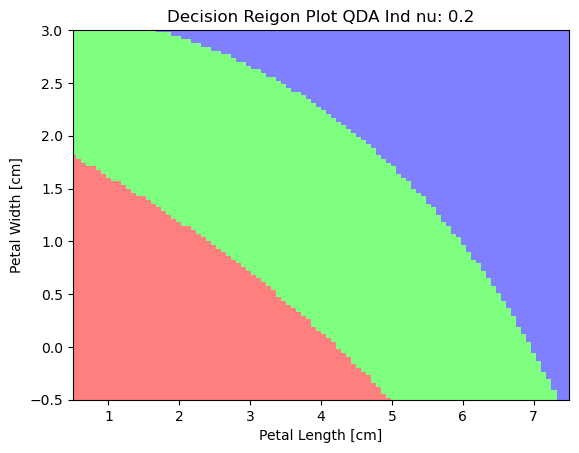

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



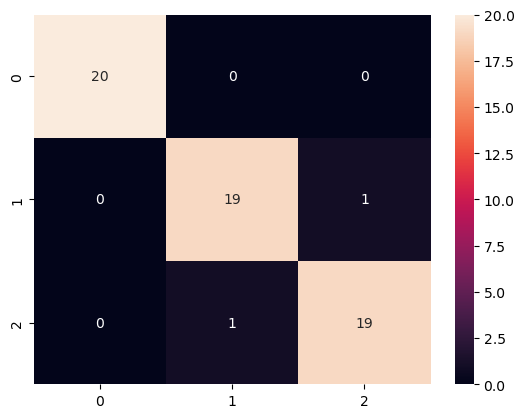

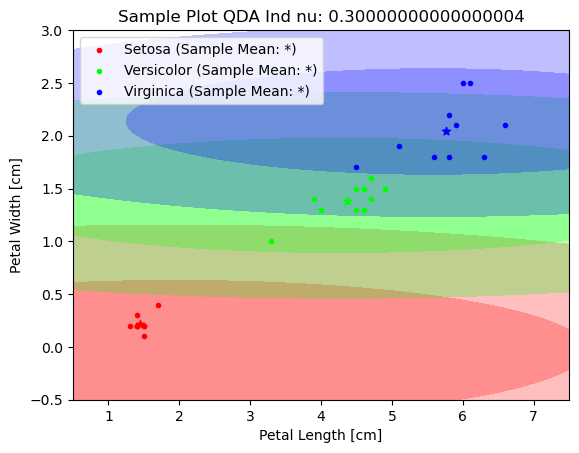

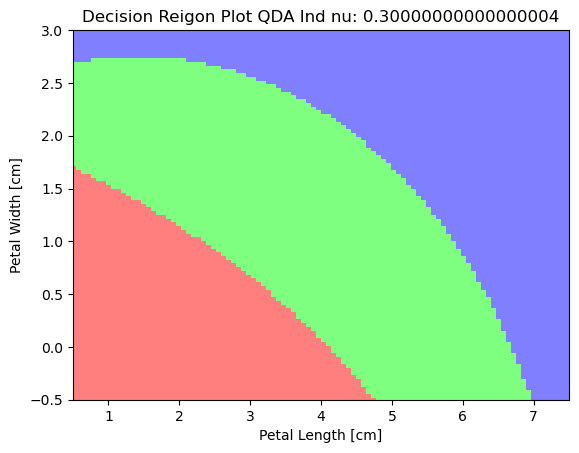

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



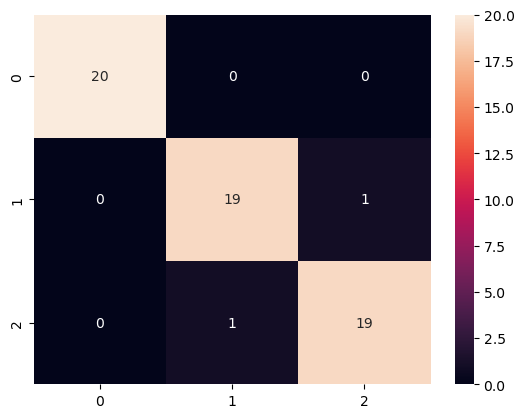

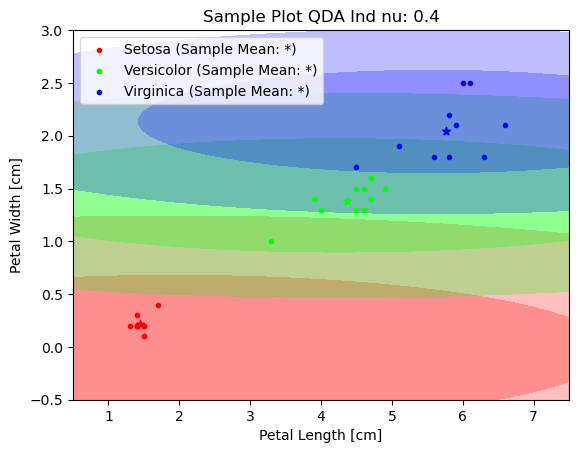

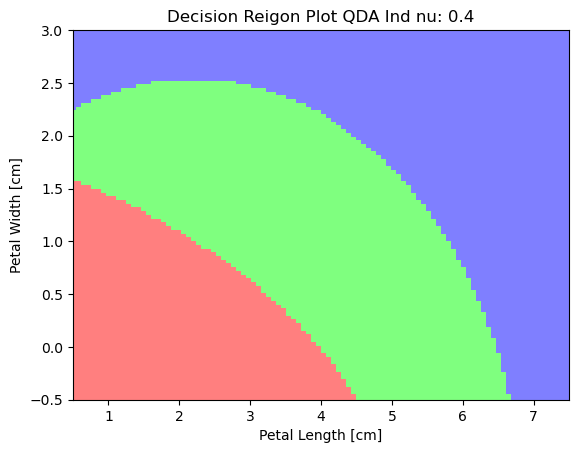

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



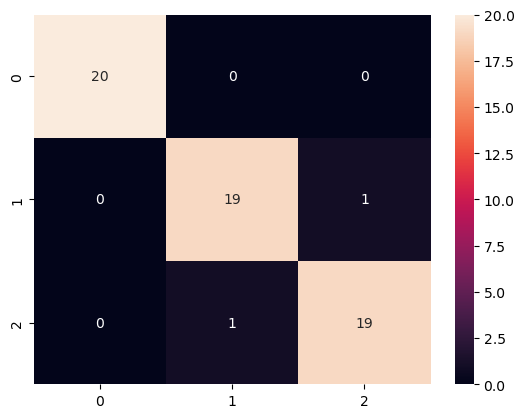

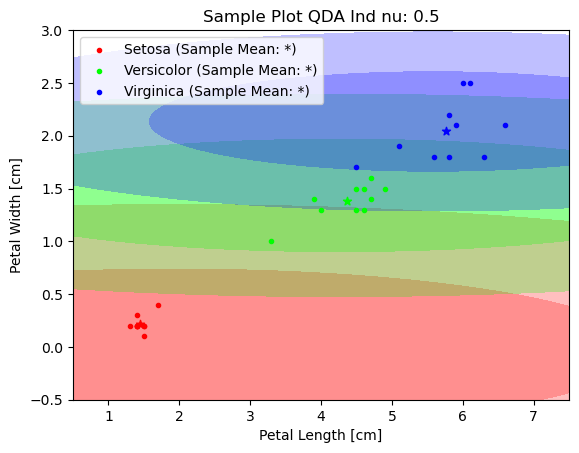

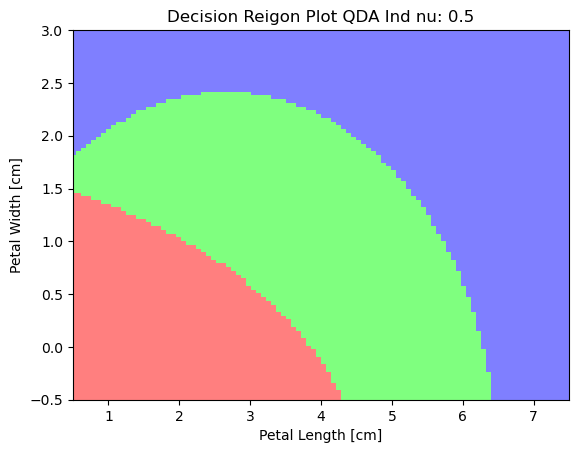

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



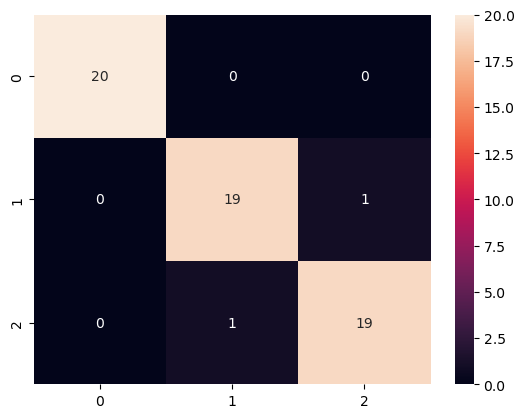

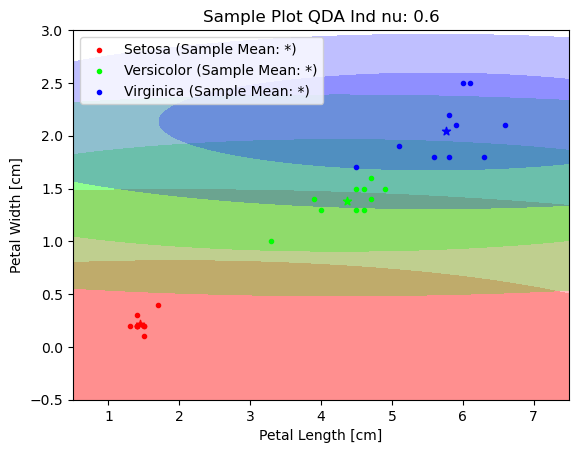

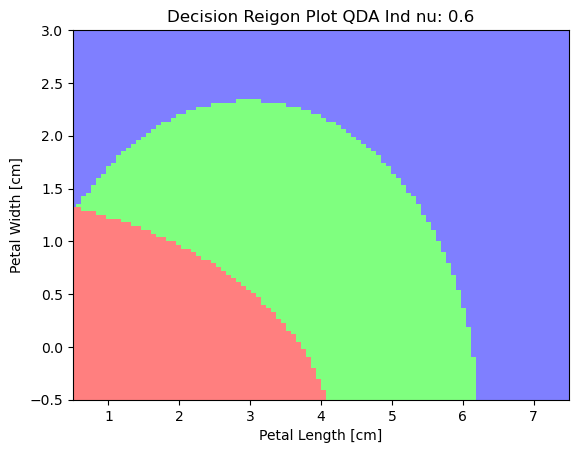

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.90      0.92        20
         2.0       0.90      0.95      0.93        20

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



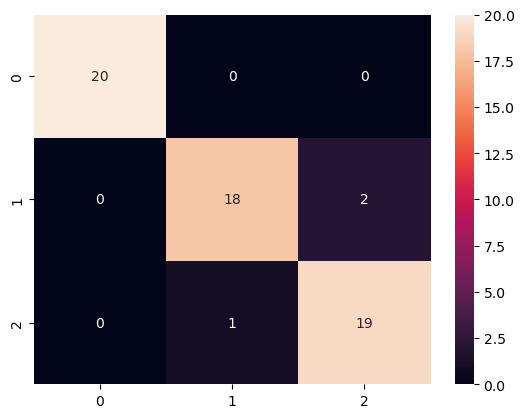

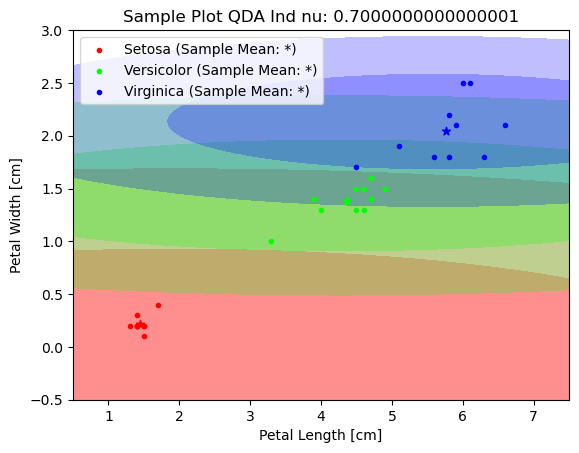

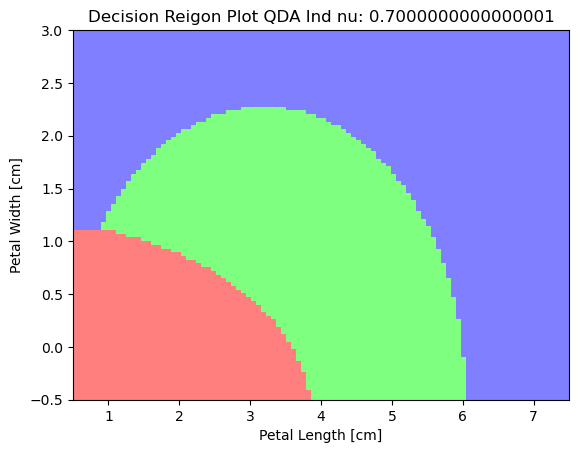

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.90      0.92        20
         2.0       0.90      0.95      0.93        20

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



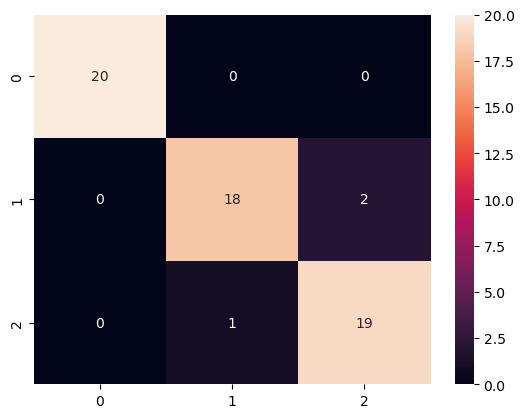

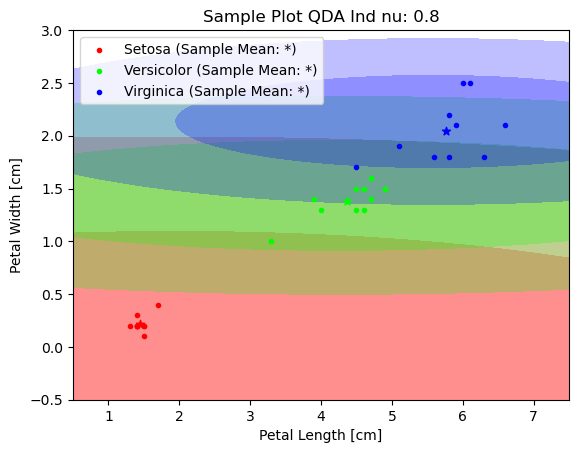

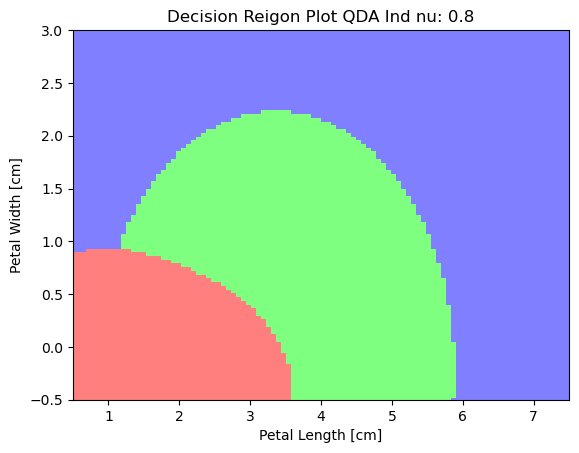

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.90      0.92        20
         2.0       0.90      0.95      0.93        20

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



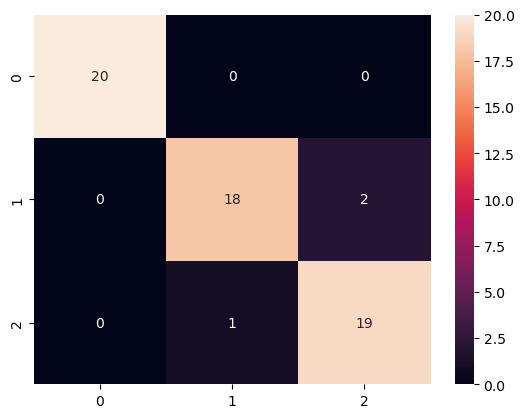

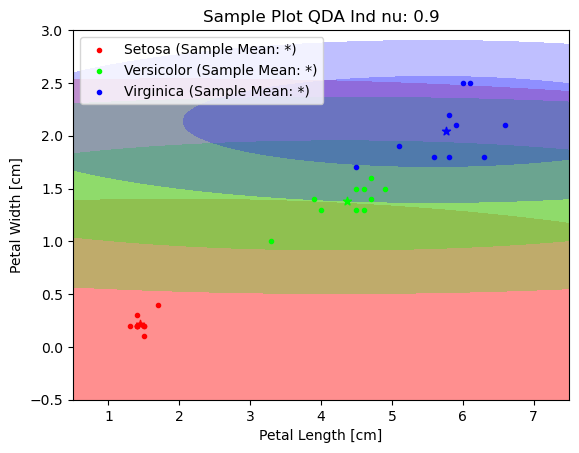

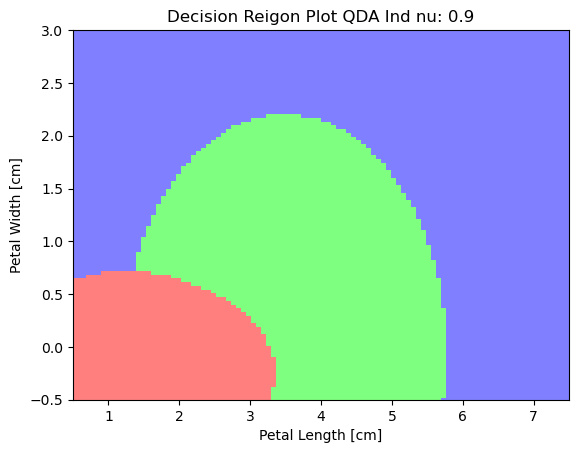

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.95      0.90      0.92        20
         2.0       0.90      0.95      0.93        20

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



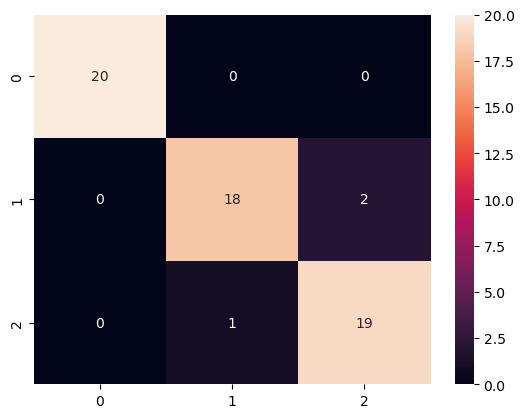

In [25]:
nus=np.arange(0.1,1.0,0.1)
for nu in nus:
    Model1=NDA(TrainX,TrainY,"QDA",nu=nu,depen='Ind')
    Model1.PlotSample()
    Model1.PlotPredictions()
    Y=Model1.Predict(ValX)
    print(classification_report(ValY,Y))
    heatmap(confusion_matrix(ValY, Y),annot=True)

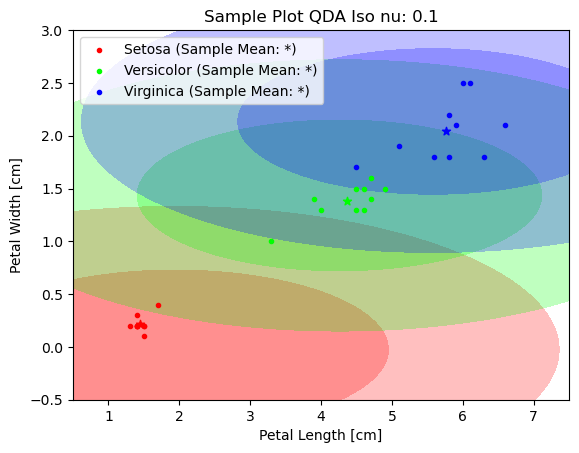

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.80      1.00      0.89        20
         2.0       1.00      0.75      0.86        20

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



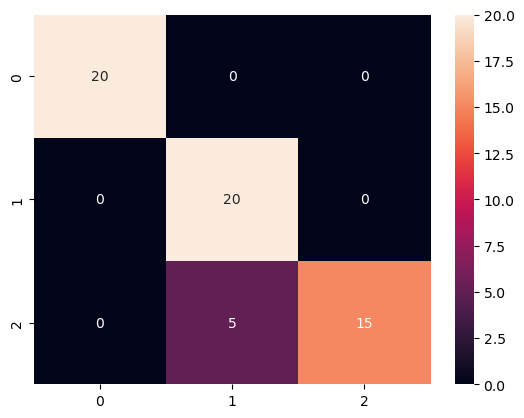

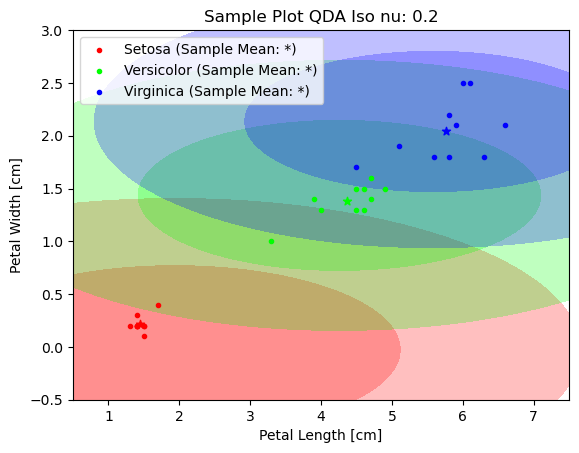

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.80      1.00      0.89        20
         2.0       1.00      0.75      0.86        20

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



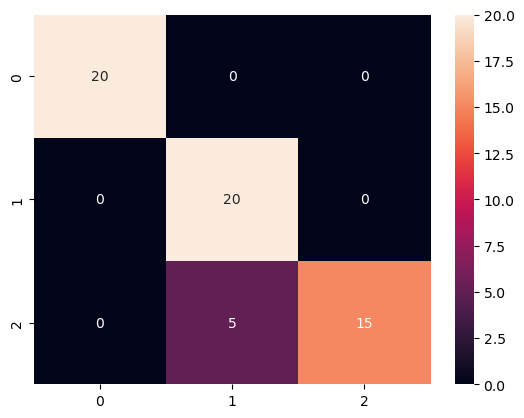

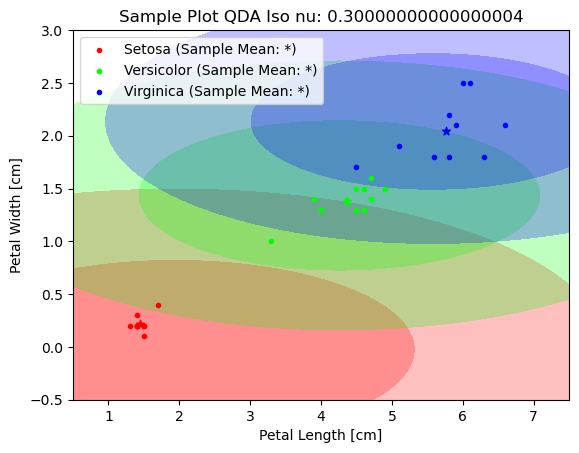

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.80      1.00      0.89        20
         2.0       1.00      0.75      0.86        20

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



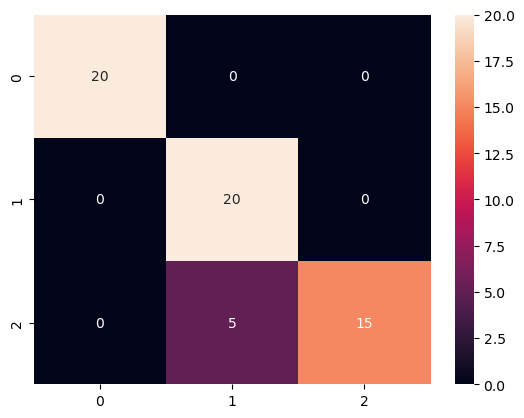

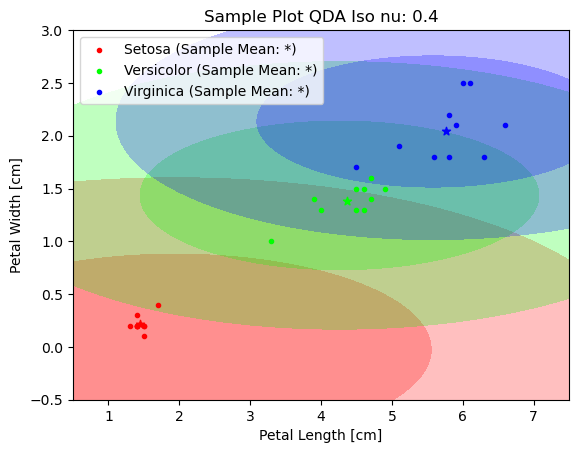

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.83      1.00      0.91        20
         2.0       1.00      0.80      0.89        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



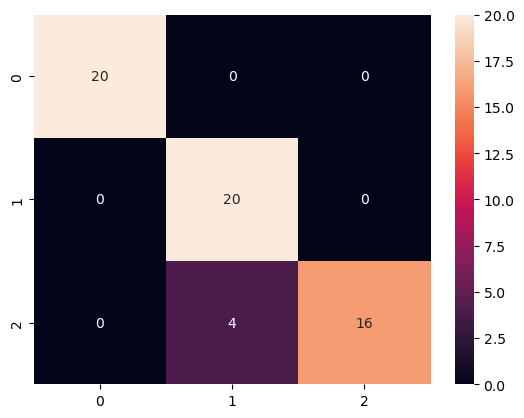

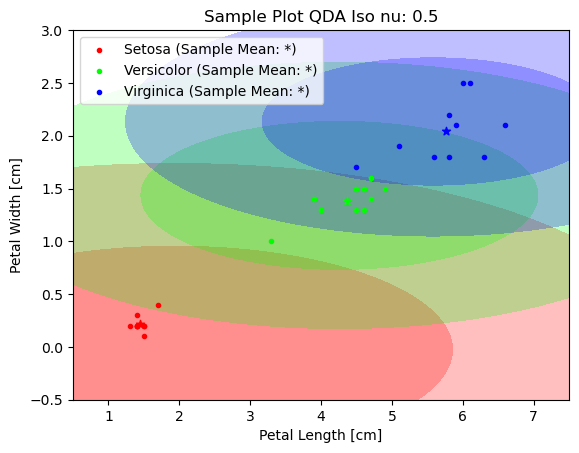

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.83      1.00      0.91        20
         2.0       1.00      0.80      0.89        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



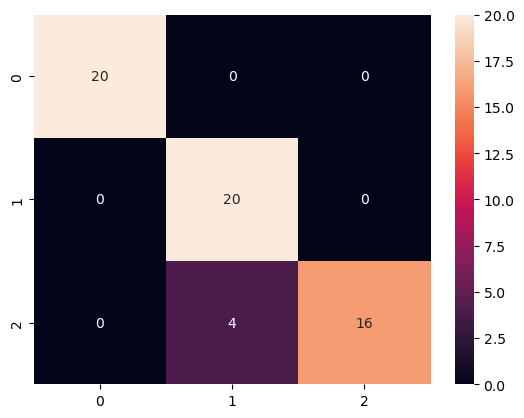

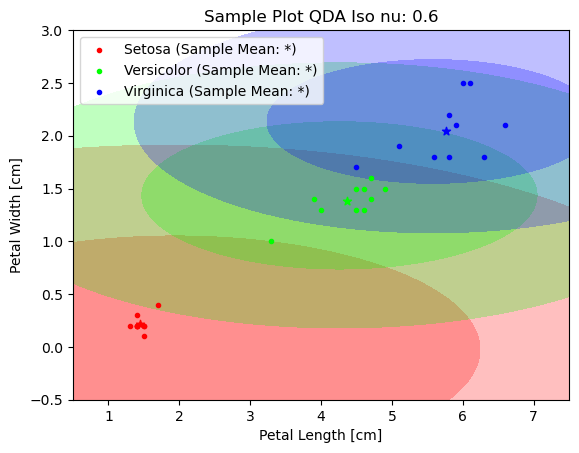

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.83      1.00      0.91        20
         2.0       1.00      0.80      0.89        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



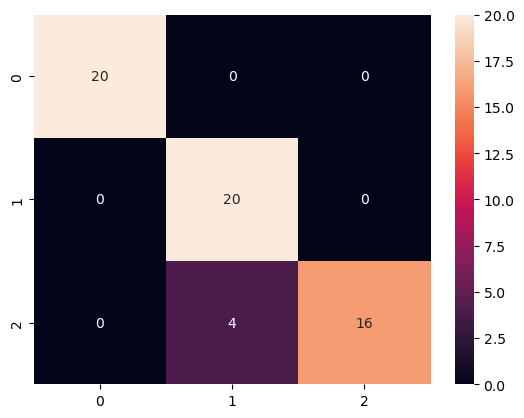

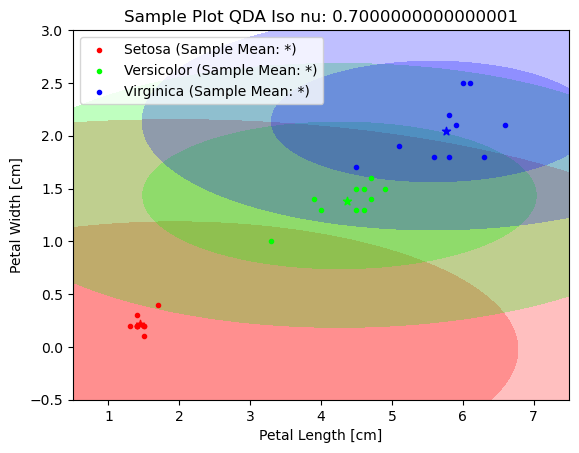

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.83      1.00      0.91        20
         2.0       1.00      0.80      0.89        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



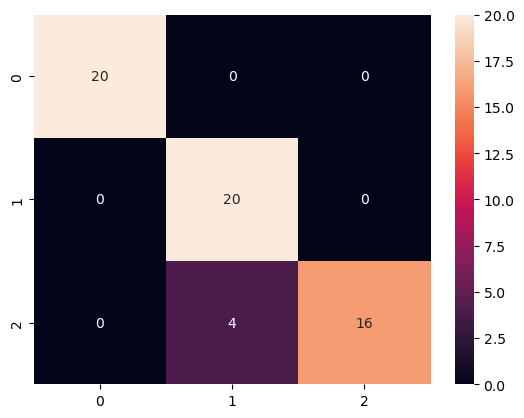

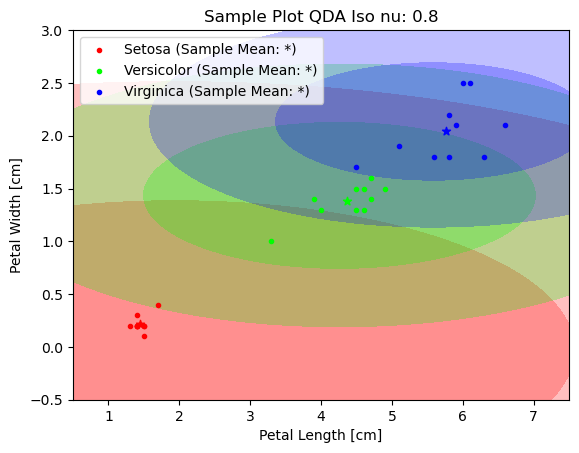

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.83      1.00      0.91        20
         2.0       1.00      0.80      0.89        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



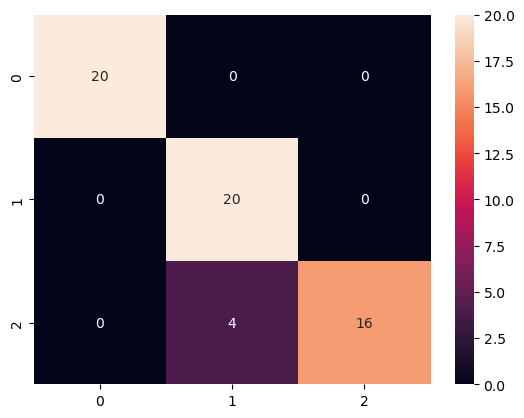

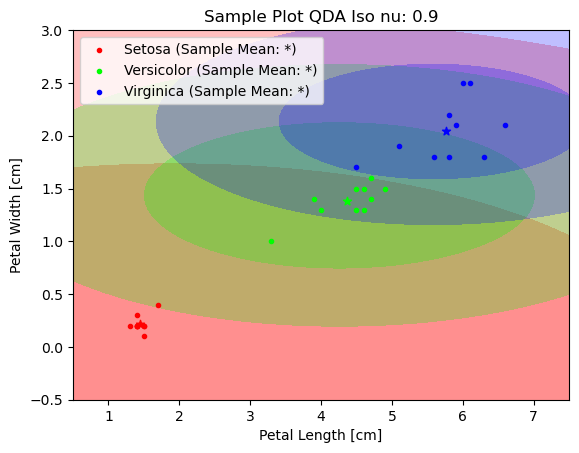

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.83      1.00      0.91        20
         2.0       1.00      0.80      0.89        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



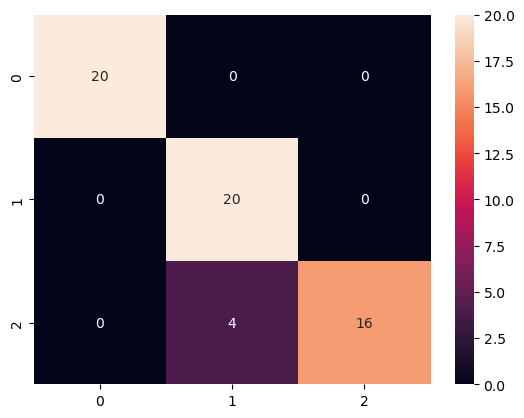

In [26]:
nus=np.arange(0.1,1.0,0.1)
for nu in nus:
    Model1=NDA(TrainX,TrainY,"QDA",nu=nu,depen='Iso')
    Model1.PlotSample()
    Y=Model1.Predict(ValX)
    print(classification_report(ValY,Y))
    heatmap(confusion_matrix(ValY, Y),annot=True)